## Customer Churn Prediction with XGBoost

*Using Gradient Boosted Trees to Predict Mobile Customer Departure*

Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use a familiar example of churn: leaving a mobile phone operator. Seems like one can always find fault with their provider du jour! And if the provider knows that a customer is thinking of leaving, it can offer timely incentives - such as a phone upgrade or perhaps having a new feature activated – and the customer may stick around. Incentives are often much more cost-effective than losing and reacquiring a customer.

### Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify

# install nlp libs
!pip install transformers

In [1]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [2]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker/TUTORIAL-churn-xgboost"

In [3]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)

### Data Ingest

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes. After all, predicting the future is tricky business! But we'll learn how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book Discovering Knowledge in Data by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. Let's download and read that dataset in now:

In [4]:
s3.download_file(f"sagemaker-sample-files", "datasets/tabular/synthetic/churn.txt", "churn.txt")

churn = pd.read_csv("./churn.txt")
pd.set_option("display.max_columns", 500)
churn

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NH,4,787,151-3162,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9,False.
4996,SD,140,836,351-5993,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4,False.
4997,SC,32,836,370-3127,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6,False.
4998,MA,142,776,604-2108,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7,True.


By modern standards, it’s a relatively small dataset, with only 5,000 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- State: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- Account Length: the number of days that this account has been active
- Area Code: the three-digit area code of the corresponding customer’s phone number
- Phone: the remaining seven-digit phone number
- Int’l Plan: whether the customer has an international calling plan: yes/no
- VMail Plan: whether the customer has a voice mail feature: yes/no
- VMail Message: the average number of voice mail messages per month
- Day Mins: the total number of calling minutes used during the day
- Day Calls: the total number of calls placed during the day
- Day Charge: the billed cost of daytime calls
- Eve Mins, Eve Calls, Eve Charge: the billed cost for calls placed during the evening
- Night Mins, Night Calls, Night Charge: the billed cost for calls placed during nighttime
- Intl Mins, Intl Calls, Intl Charge: the billed cost for international calls
- CustServ Calls: the number of calls placed to Customer Service
- Churn?: whether the customer left the service: true/false

The last attribute, Churn?, is known as the target attribute: the attribute that we want the ML model to predict. Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

### Data Exploration

col_0,% observations
State,
AK,0.0170
AL,0.0200
AR,0.0220
AZ,0.0180
CA,0.0208
CO,0.0182
CT,0.0178
DC,0.0224
DE,0.0182


col_0,% observations
Phone,
100-2030,0.0002
100-2118,0.0002
100-3505,0.0002
100-5224,0.0002
101-3371,0.0002
...,...
999-3178,0.0002
999-5498,0.0002
999-5816,0.0002


col_0,% observations
Int'l Plan,
no,0.5014
yes,0.4986


col_0,% observations
VMail Plan,
no,0.4976
yes,0.5024


col_0,% observations
Churn?,
False.,0.5004
True.,0.4996


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


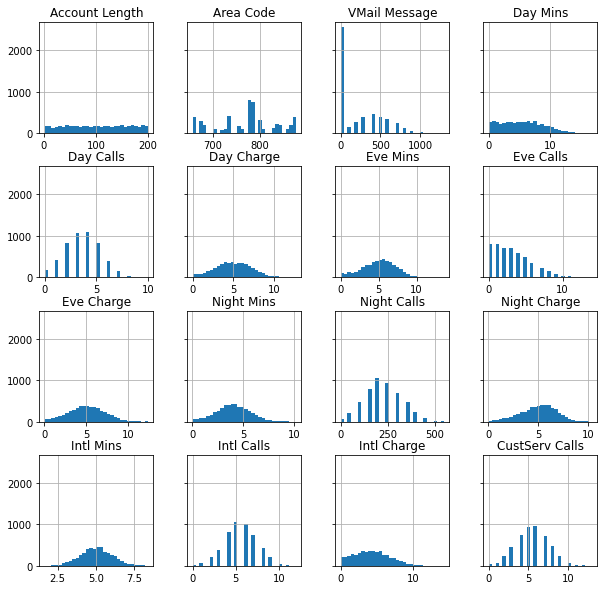

In [5]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=["object"]).columns:
    display(pd.crosstab(index=churn[column], columns="% observations", normalize="columns"))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that:

- State appears to be quite evenly distributed.
- Phone takes on too many unique values to be of any practical use. It's possible that parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. VMail Message is a notable exception (and Area Code showing up as a feature we should convert to non-numeric).

In [6]:
churn = churn.drop("Phone", axis=1)
churn["Area Code"] = churn["Area Code"].astype(object)

Next let's look at the relationship between each of the features and our target variable.

Churn?,False.,True.
State,,
AK,0.015588,0.018415
AL,0.021583,0.018415
AR,0.022782,0.021217
AZ,0.015588,0.020416
CA,0.020384,0.021217
CO,0.018785,0.017614
CT,0.015588,0.020016
DC,0.022382,0.022418
DE,0.018385,0.018014


Churn?,False.,True.
Area Code,,
657,0.037170,0.036829
658,0.022782,0.021217
659,0.015588,0.020416
676,0.020384,0.021217
677,0.018785,0.017614
678,0.015588,0.020016
686,0.040767,0.040432
707,0.019984,0.015612
716,0.017986,0.015212


Churn?,False.,True.
Int'l Plan,,
no,0.5,0.502802
yes,0.5,0.497198


Churn?,False.,True.
VMail Plan,,
no,0.496403,0.498799
yes,0.503597,0.501201


Account Length


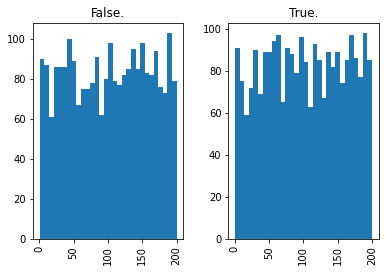

VMail Message


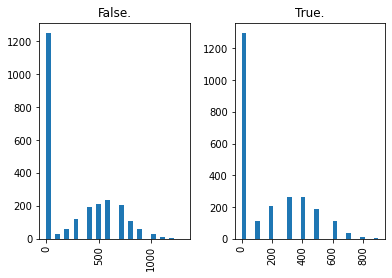

Day Mins


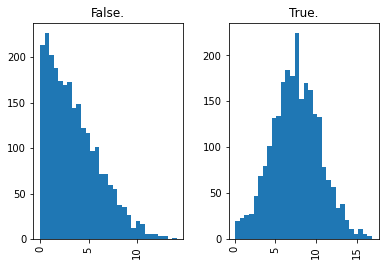

Day Calls


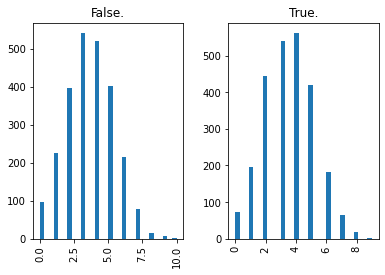

Day Charge


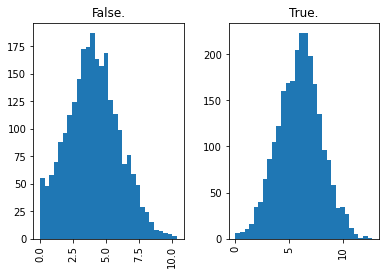

Eve Mins


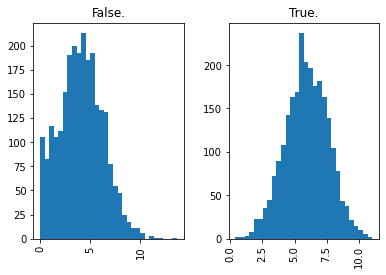

Eve Calls


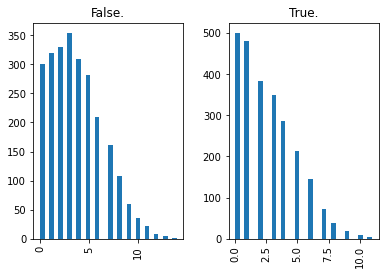

Eve Charge


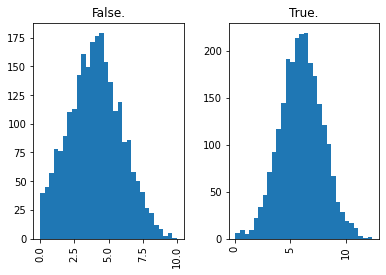

Night Mins


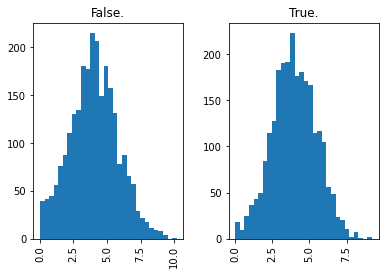

Night Calls


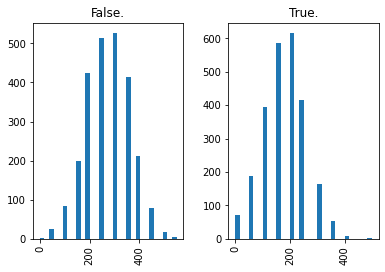

Night Charge


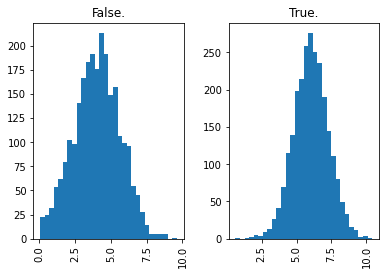

Intl Mins


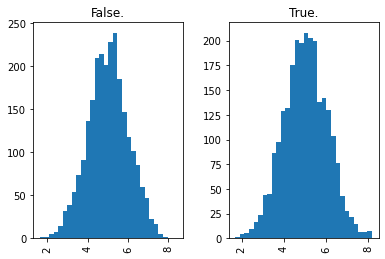

Intl Calls


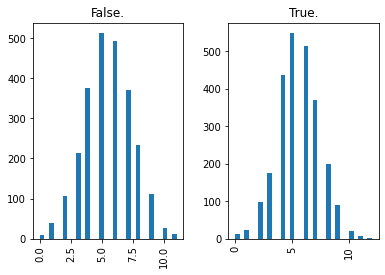

Intl Charge


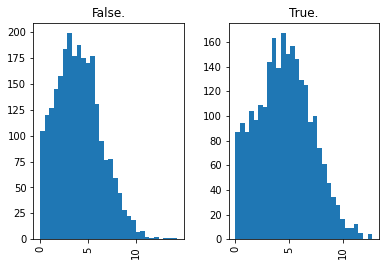

CustServ Calls


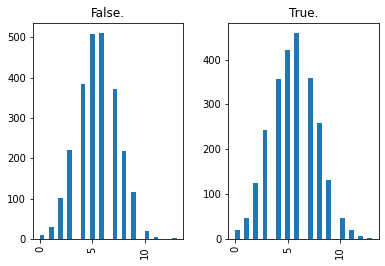

In [7]:
for column in churn.select_dtypes(include=["object"]).columns:
    if column != "Churn?":
        display(pd.crosstab(index=churn[column], columns=churn["Churn?"], normalize="columns"))

for column in churn.select_dtypes(exclude=["object"]).columns:
    print(column)
    hist = churn[[column, "Churn?"]].hist(by="Churn?", bins=30)
    plt.show()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.009030,-0.015878,0.011659,-0.007468,0.000213,0.026515,-0.012795,0.016400,-0.002383,-0.034925,0.017277,-0.003735,0.028285,-0.036721
VMail Message,-0.009030,1.000000,-0.143272,0.002762,-0.182712,-0.104667,-0.101240,-0.029212,0.061370,0.135042,-0.155475,-0.015162,0.131964,0.010120,0.068657
Day Mins,-0.015878,-0.143272,1.000000,-0.087598,0.667941,0.482641,-0.184939,0.766489,0.188190,-0.445212,0.570508,0.001988,0.236131,0.239331,-0.195322
Day Calls,0.011659,0.002762,-0.087598,1.000000,-0.222556,0.033903,0.185881,-0.052051,-0.085222,-0.083050,0.046641,-0.022548,-0.045671,-0.120064,-0.065518
Day Charge,-0.007468,-0.182712,0.667941,-0.222556,1.000000,0.574697,0.236626,0.371580,0.150700,-0.130722,0.374861,0.010294,0.119584,0.251748,-0.260945
Eve Mins,0.000213,-0.104667,0.482641,0.033903,0.574697,1.000000,-0.067123,0.269980,-0.090515,0.067315,0.317481,-0.015678,0.070456,0.448910,-0.167347
Eve Calls,0.026515,-0.101240,-0.184939,0.185881,0.236626,-0.067123,1.000000,-0.467814,0.221439,0.218149,-0.324936,-0.001593,-0.112062,0.017036,-0.433467
Eve Charge,-0.012795,-0.029212,0.766489,-0.052051,0.371580,0.269980,-0.467814,1.000000,0.184230,-0.454649,0.546137,-0.003569,0.164104,0.243936,-0.011019
Night Mins,0.016400,0.061370,0.188190,-0.085222,0.150700,-0.090515,0.221439,0.184230,1.000000,-0.223023,-0.140482,-0.012781,0.038831,0.271179,-0.332802
Night Calls,-0.002383,0.135042,-0.445212,-0.083050,-0.130722,0.067315,0.218149,-0.454649,-0.223023,1.000000,-0.390333,-0.009821,0.181237,-0.155736,0.110211


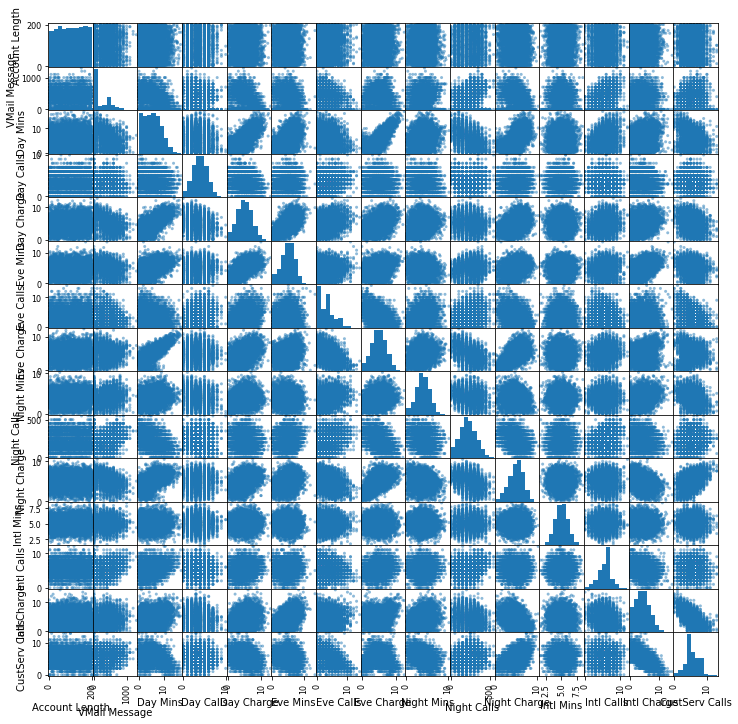

In [8]:
display(churn.corr())
pd.plotting.scatter_matrix(churn, figsize=(12, 12))
plt.show()

We see several features that essentially have 100% correlation with one another. Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias. Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [9]:
churn = churn.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

Now that we've cleaned up our dataset, let's determine which algorithm to use. As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn. In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms. Instead, let's attempt to model this problem using gradient boosted trees. Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint. XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format. For this example, we'll stick with CSV. It should:

- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

In [10]:
model_data = pd.get_dummies(churn)
model_data = pd.concat(
    [model_data["Churn?_True."], model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)], axis=1
)

And now let's split the data into training, validation, and test sets. This will help prevent us from overfitting the model, and allow us to test the model's accuracy on data it hasn't already seen.



In [12]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

Now we'll upload these files to S3.

In [13]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

### Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [14]:
container = sagemaker.image_uris.retrieve("xgboost", region, "latest")
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

Then, because we're training with the CSV file format, we'll create `TrainingInputs` that our training function can use as a pointer to the files in S3.

In [15]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between numerous shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyper-parameters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [16]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective="binary:logistic",
    num_round=100,
)

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

2022-06-10 05:21:10 Starting - Starting the training job...ProfilerReport-1654838468: InProgress
...
2022-06-10 05:22:00 Starting - Preparing the instances for training.........
2022-06-10 05:23:40 Downloading - Downloading input data...
2022-06-10 05:24:10 Training - Downloading the training image......
2022-06-10 05:25:16 Uploading - Uploading generated training modelArguments: train
[2022-06-10:05:25:05:INFO] Running standalone xgboost training.
[2022-06-10:05:25:05:INFO] File size need to be processed in the node: 1.15mb. Available memory size in the node: 8458.99mb
[2022-06-10:05:25:05:INFO] Determined delimiter of CSV input is ','
[05:25:05] S3DistributionType set as FullyReplicated
[05:25:05] 3500x99 matrix with 346500 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-06-10:05:25:05:INFO] Determined delimiter of CSV input is ','
[05:25:05] S3DistributionType set as FullyReplicated
[05:25:05] 1000x99 matrix with 99000 entries loaded from /op

### Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [17]:
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

---------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making a `http` POST request.  But first, we'll need to set up serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [18]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return np.fromstring(predictions[1:], sep=",")


predictions = predict(test_data.to_numpy()[:, 1:])

In [19]:
print(predictions)

[1.35331511e-01 9.82077539e-01 1.02474750e-03 4.05021757e-03
 3.92824411e-01 9.72177207e-01 9.91238415e-01 7.27955222e-01
 8.88106227e-01 9.90995705e-01 9.52816725e-01 1.19172679e-02
 3.58281261e-03 9.42603052e-01 9.89126205e-01 9.90786612e-01
 9.89062250e-01 6.96188286e-02 9.03073490e-01 9.86119509e-01
 9.62791502e-01 1.74614764e-03 5.25158504e-03 9.58006740e-01
 9.41856503e-01 1.67768657e-01 9.90760803e-01 2.84090172e-03
 9.95878816e-01 1.79207008e-02 5.64881638e-02 3.02827973e-02
 9.39479709e-01 5.42096049e-03 4.67779767e-03 1.76512660e-03
 5.74744403e-01 4.61890012e-01 9.82370138e-01 9.46011901e-01
 7.24184453e-01 9.79002118e-01 4.35622185e-01 9.47760344e-01
 1.98116549e-03 9.55070615e-01 1.80402584e-03 2.31066555e-01
 9.84024167e-01 2.06405832e-03 4.47656447e-03 9.76536214e-01
 9.76774156e-01 2.38812685e-01 8.62769634e-02 9.92498100e-01
 5.51647916e-02 1.81831885e-03 1.40864691e-02 6.51788637e-02
 3.24071288e-01 9.69274342e-01 8.70716691e-01 2.77617481e-02
 3.38171422e-03 9.865017

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a confusion matrix.

In [20]:
pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,0.0,1.0
actual,,
0,235,18
1,9,238


_Note, due to randomized elements of the algorithm, your results may differ slightly._

Of the 48 churners, we've correctly predicted 39 of them (true positives). We also incorrectly predicted 4 customers would churn who then ended up not doing so (false positives).  There are also 9 customers who ended up churning, that we predicted would not (false negatives).

An important point here is that because of the `np.round()` function above, we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` yield continuous values between 0 and 1, and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider lowering this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

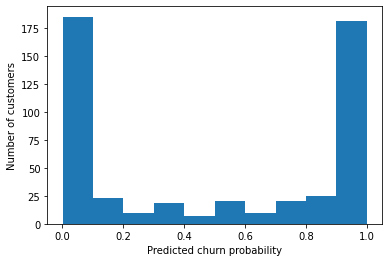

In [21]:
plt.hist(predictions)
plt.xlabel("Predicted churn probability")
plt.ylabel("Number of customers")
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [22]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
Churn?_True.,,
0,215,38
1,3,244


We can see that lowering the cutoff from 0.5 to 0.3 results in 1 more true positive, 3 more false positives, and 1 fewer false negative. The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed anyway.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.


### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with deterministic rules instead of ML.

More important, if we put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. We also need to look at similar costs associated with correct predictions of true positives and true negatives.  Because the choice of the cutoff affects all four of these statistics, we need to consider the relative costs to the business for each of these four outcomes for each prediction.

### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \\$100. If a provider offered a customer such a concession, they may think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the \\$100 concession. We probably could have spent that \$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this is to simply run a simulation over numerous possible cutoffs.  We test 100 possible values in the for-loop below.

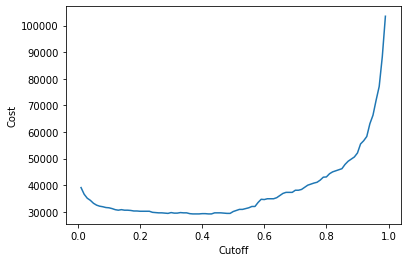

In [23]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(
        np.sum(
            np.sum(
                np.array([[0, 100], [500, 100]])
                * pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > c, 1, 0))
            )
        )
    )

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.xlabel("Cutoff")
plt.ylabel("Cost")
plt.show()

In [24]:
print(
    "Cost is minimized near a cutoff of:",
    cutoffs[np.argmin(costs)],
    "for a cost of:",
    np.min(costs),
)

Cost is minimized near a cutoff of: 0.37 for a cost of: 29200


The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly.  The overall cost can be minimized at \\$8400 by setting the cutoff to 0.46, which is substantially better than the \$20k+ we would expect to lose by not taking any action.

### Extensions

This notebook showcased how to build a model that predicts whether a customer is likely to churn, and then how to optimally set a threshold that accounts for the cost of true positives, false positives, and false negatives.  There are several means of extending it including:
- Some customers who receive retention incentives will still churn.  Including a probability of churning despite receiving an incentive in our cost function would provide a better ROI on our retention programs.
- Customers who switch to a lower-priced plan or who deactivate a paid feature represent different kinds of churn that could be modeled separately.
- Modeling the evolution of customer behavior. If usage is dropping and the number of calls placed to Customer Service is increasing, you are more likely to experience churn then if the trend is the opposite. A customer profile should incorporate behavior trends.
- Actual training data and monetary cost assignments could be more complex.
- Multiple models for each type of churn could be needed.

Regardless of additional complexity, similar principles described in this notebook are likely applied.

### Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [25]:
xgb_predictor.delete_endpoint()

## Hugging Face Sentiment Classification

*Binary Classification with Trainer and sst2 dataset*

Welcome to our end-to-end binary text classification example. This notebook uses Hugging Face's `transformers` library with a custom Amazon sagemaker-sdk extension to fine-tune a pre-trained transformer on binary text classification. The pre-trained model is fine-tuned using the `sst2` dataset. To get started, we need to set up the environment with a few prerequisite steps for permissions, configurations, and so on. 

This notebook is adapted from Hugging Face's notebook [Huggingface Sagemaker-sdk - Getting Started Demo](https://github.com/huggingface/notebooks/blob/master/sagemaker/01_getting_started_pytorch/sagemaker-notebook.ipynb) and provided here courtesy of Hugging Face.

### Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify
!pip install s3fs

# install nlp libs
!pip install transformers
!pip install datasets[s3]

In [31]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
import botocore
from datasets.filesystems import S3FileSystem

from datasets import Dataset
from transformers import AutoTokenizer
import sagemaker.huggingface

In [30]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker/TUTORIAL-sentiment-sst2"
tokenizer_name = "distilbert-base-uncased" # Tokenizer used in pre-processing

In [ ]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)
cw = boto3.Session().client(service_name="cloudwatch", region_name=region)

### Data Ingest

We use the `datasets` library to pre-process the `sst2` dataset (Stanford Sentiment Treebank). After pre-processing, the dataset is uploaded to the `sagemaker_session_bucket` for use within the training job. The [sst2](https://nlp.stanford.edu/sentiment/index.html) dataset consists of 67349 training samples and _ testing samples of highly polar movie reviews.

In [32]:
# Download the SST2 data from s3
!curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/text/SST2/sst2.test > ./sst2.test
!curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/text/SST2/sst2.train > ./sst2.train
!curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/text/SST2/sst2.val > ./sst2.val

# Tokenize sentences
# Download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Tokenizer helper function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

# Load dataset
test_df = pd.read_csv("sst2.test", sep="delimiter", header=None, engine="python", names=["line"])
train_df = pd.read_csv("sst2.train", sep="delimiter", header=None, engine="python", names=["line"])

test_df[["label", "text"]] = test_df["line"].str.split(" ", 1, expand=True)
train_df[["label", "text"]] = train_df["line"].str.split(" ", 1, expand=True)

test_df.drop("line", axis=1, inplace=True)
train_df.drop("line", axis=1, inplace=True)

test_df["label"] = pd.to_numeric(test_df["label"], downcast="integer")
train_df["label"] = pd.to_numeric(train_df["label"], downcast="integer")

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for pytorch
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Upload data to `sagemaker_session_bucket`
# After processing the `datasets`, we use the `FileSystem` [integration]
# (https://huggingface.co/docs/datasets/filesystems.html) to upload the dataset to S3.
s3 = S3FileSystem()

# save train_dataset to s3
training_input_path = f"s3://{sess.default_bucket()}/{prefix}/train"
train_dataset.save_to_disk(training_input_path, fs=s3)

# save test_dataset to s3
test_input_path = f"s3://{sess.default_bucket()}/{prefix}/test"
test_dataset.save_to_disk(test_input_path, fs=s3)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189k  100  189k    0     0   715k      0 --:--:-- --:--:-- --:--:--  715k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3716k  100 3716k    0     0  8892k      0 --:--:-- --:--:-- --:--:-- 8892k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 94916  100 94916    0     0   461k      0 --:--:-- --:--:-- --:--:--  463k


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/68 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

### Fine-tune the model and start a SageMaker training job

In order to create a SageMaker training job, we need a `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In an Estimator, we define which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in, etc:



```python
hf_estimator = HuggingFace(entry_point="train.py",
                            source_dir="./scripts",
                            base_job_name="huggingface-sdk-extension",
                            instance_type="ml.p3.2xlarge",
                            instance_count=1,
                            transformers_version="4.4",
                            pytorch_version="1.6",
                            py_version="py36",
                            role=role,
                            hyperparameters = {"epochs": 1,
                                               "train_batch_size": 32,
                                               "model_name":"distilbert-base-uncased"
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required EC2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py`, and downloads the data from the `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running:

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` defined in the `HuggingFace` estimator are passed in as named arguments. 

SageMaker provides useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string representing the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string representing the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the Hugging Face estimator's `fit()` call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run the training job locally, you can define `instance_type="local"` or `instance_type="local_gpu"` for GPU usage.

_Note: local mode is not supported in SageMaker Studio._


In [35]:
!mkdir -p scripts

In [36]:
%%writefile scripts/train.py
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_from_disk
import random
import logging
import sys
import argparse
import os
import torch

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # Hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_argument("--output_data_dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])
    parser.add_argument("--model_dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--n_gpus", type=str, default=os.environ["SM_NUM_GPUS"])
    parser.add_argument("--training_dir", type=str, default=os.environ["SM_CHANNEL_TRAIN"])
    parser.add_argument("--test_dir", type=str, default=os.environ["SM_CHANNEL_TEST"])

    args, _ = parser.parse_known_args()

    # Set up logging
    logger = logging.getLogger(__name__)

    logging.basicConfig(
        level=logging.getLevelName("INFO"),
        handlers=[logging.StreamHandler(sys.stdout)],
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    )

    # Load datasets
    train_dataset = load_from_disk(args.training_dir)
    test_dataset = load_from_disk(args.test_dir)

    logger.info(f"Loaded train_dataset length is: {len(train_dataset)}")
    logger.info(f"Loaded test_dataset length is: {len(test_dataset)}")

    # Compute metrics function for binary classification
    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

    # Download model from model hub
    model = AutoModelForSequenceClassification.from_pretrained(args.model_name)
    tokenizer = AutoTokenizer.from_pretrained(args.model_name)

    # Define training args
    training_args = TrainingArguments(
        output_dir=args.model_dir,
        num_train_epochs=args.epochs,
        per_device_train_batch_size=args.train_batch_size,
        per_device_eval_batch_size=args.eval_batch_size,
        warmup_steps=args.warmup_steps,
        evaluation_strategy="epoch",
        logging_dir=f"{args.output_data_dir}/logs",
        learning_rate=float(args.learning_rate),
    )

    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )

    # Train model
    trainer.train()

    # Evaluate model
    eval_result = trainer.evaluate(eval_dataset=test_dataset)

    # Write eval result to file which can be accessed later in S3 ouput
    with open(os.path.join(args.output_data_dir, "eval_results.txt"), "w") as writer:
        print(f"***** Eval results *****")
        for key, value in sorted(eval_result.items()):
            writer.write(f"{key} = {value}\n")

    # Save the model to s3
    trainer.save_model(args.model_dir)

Writing scripts/train.py


In [ ]:
from sagemaker.huggingface import HuggingFace

# Hyperparameters which are passed into the training job
hyperparameters = {"epochs": 1, "train_batch_size": 32, "model_name": "distilbert-base-uncased"}

hf_estimator = HuggingFace(
    entry_point="train.py",
    source_dir="./scripts",
    instance_type="ml.p3.2xlarge",
    instance_count=1,
    role=role,
    transformers_version="4.12",
    pytorch_version="1.9",
    py_version="py38",
    hyperparameters=hyperparameters,
)

# Start the training job with the uploaded dataset as input
hf_estimator.fit({"train": training_input_path, "test": test_input_path})

### Deploy the endpoint

To deploy the endpoint, call `deploy()` on the HuggingFace estimator object, passing in the desired number of instances and instance type.

In [ ]:
predictor = hf_estimator.deploy(1, "ml.p3.2xlarge")

Then use the returned predictor object to perform inference.

In [ ]:
sentiment_input = {"inputs": "I love using the new Inference DLC."}

predictor.predict(sentiment_input)

[{'label': 'LABEL_1', 'score': 0.9633631706237793}]

We see that the fine-tuned model classifies the test sentence "I love using the new Inference DLC." as having positive sentiment with 98% probability!

Finally, delete the endpoint.

In [ ]:
predictor.delete_endpoint()

## Text Classification with Amazon SageMaker BlazingText and Hyperparameter Tuning

Automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many jobs that test a range of hyperparameters on your dataset. You choose the tunable hyperparameters, a range of values for each, and an objective metric. You choose the objective metric from the metrics that the algorithm computes. Automatic model tuning searches the hyperparameters chosen to find the combination of values that result in the model that optimizes the objective metric.

Text Classification can be used to solve various use-cases like sentiment analysis, spam detection, hashtag prediction etc. This notebook demonstrates the use of SageMaker BlazingText to perform supervised binary/multi class with single or multi label text classification. BlazingText can train the model on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algorithms. BlazingText extends the `fastText` text classifier to leverage GPU acceleration using custom `CUDA` kernels.

### Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify
!pip install s3fs

# install nlp libs
!pip install transformers
!pip install datasets[s3]

In [ ]:
from sklearn.datasets._tw

In [56]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
import botocore
from datasets.filesystems import S3FileSystem
import shutil

import sagemaker
import string
from sklearn.model_selection import train_test_split

# Download the `nltk` tokenizer and other libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

from sklearn.datasets._twenty_newsgroups import (
    strip_newsgroup_header,
    strip_newsgroup_quoting,
    strip_newsgroup_footer,
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker/TUTORIAL-blazingtext-newsgroup"

In [ ]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)

### Data Ingest

Now we'll download a dataset from the web on which we want to train the text classification model. BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence and the corresponding label(s) prefixed by "\__label\__".

In this example, let us train the text classification model on the [`20 newsgroups dataset`](http://qwone.com/~jason/20Newsgroups/). The `20 newsgroups dataset` consists of 20000 messages taken from 20 Usenet newsgroups.

In [50]:
data_dir = "20_newsgroups_bulk"
if os.path.exists(data_dir):  # cleanup existing data folder
    shutil.rmtree(data_dir)

!aws s3 cp s3://sagemaker-sample-files/datasets/text/20_newsgroups/20_newsgroups_bulk.tar.gz .
!tar xzf 20_newsgroups_bulk.tar.gz

file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
print("Number of files:", len(file_list))

documents_count = 0
for file in file_list:
    df = pd.read_csv(file, header=None, names=["text"])
    documents_count = documents_count + df.shape[0]
print("Number of documents:", documents_count)

categories_list = [f.split("/")[1] for f in file_list]
categories_list

download: s3://sagemaker-sample-files/datasets/text/20_newsgroups/20_newsgroups_bulk.tar.gz to ./20_newsgroups_bulk.tar.gz
Number of files: 20
Number of documents: 19997


['alt.atheism',
 'comp.sys.ibm.pc.hardware',
 'rec.motorcycles',
 'soc.religion.christian',
 'talk.politics.guns',
 'misc.forsale',
 'sci.electronics',
 'talk.religion.misc',
 'sci.crypt',
 'talk.politics.mideast',
 'comp.os.ms-windows.misc',
 'sci.space',
 'talk.politics.misc',
 'rec.sport.baseball',
 'comp.windows.x',
 'comp.graphics',
 'sci.med',
 'comp.sys.mac.hardware',
 'rec.autos',
 'rec.sport.hockey']

Let us inspect the dataset to get some understanding about how the data and the label is provided in the dataset. 

In [51]:
df = pd.read_csv("./20_newsgroups_bulk/rec.motorcycles", header=None, names=["text"])
df

,text
0,Newsgroups: rec.motorcycles\nPath: cantaloupe....
1,Newsgroups: rec.motorcycles\nPath: cantaloupe....
2,Newsgroups: rec.motorcycles\nPath: cantaloupe....
3,Newsgroups: rec.motorcycles\nPath: cantaloupe....
4,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...
...,...
995,Path: cantaloupe.srv.cs.cmu.edu!rochester!corn...
996,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...
997,Newsgroups: rec.motorcycles\nPath: cantaloupe....
998,Newsgroups: rec.motorcycles\nPath: cantaloupe....


In [52]:
df["text"][0]

'Newsgroups: rec.motorcycles\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!agate!linus!linus.mitre.org!mbunix.mitre.org!cookson\nFrom: cookson@mbunix.mitre.org (Cookson)\nSubject: Volvo Attack!\nMessage-ID: <1993Apr21.143403.4644@linus.mitre.org>\nSender: news@linus.mitre.org (News Service)\nNntp-Posting-Host: mbunix.mitre.org\nOrganization: The MITRE Corp., Bedford, Ma.\nDate: Wed, 21 Apr 1993 14:34:03 GMT\nLines: 22\n\nI was privelged enough to experience my first Volvo attack this weekend.\n\nI was last in a line of traffic that was about 6 vehicles long, riding\ndown Rt. 40 in Groton Ma.  At the side of the road, sitting off on the\nshoulder was the killer Volvo in question.  No brake lights, no turn signal,\nnothing.  We were doing about 40 mph and I was following the cage in front\nof me about 2.5-3 sec. back.  Well, as said cage passes the Volvo, the\nBrain Dead Idiot (tm) behind the wheel decides that she 

In [53]:
df = pd.read_csv("./20_newsgroups_bulk/comp.sys.mac.hardware", header=None, names=["text"])
df

,text
0,Newsgroups: comp.sys.mac.hardware\nPath: canta...
1,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....
2,Newsgroups: comp.sys.mac.hardware\nPath: canta...
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...
4,Newsgroups: comp.sys.mac.hardware\nPath: canta...
...,...
995,Newsgroups: comp.sys.mac.hardware\nPath: canta...
996,Xref: cantaloupe.srv.cs.cmu.edu comp.sys.ibm.p...
997,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....
998,Newsgroups: comp.sys.mac.hardware\nPath: canta...


In [54]:
df["text"][0]

'Newsgroups: comp.sys.mac.hardware\nPath: cantaloupe.srv.cs.cmu.edu!rochester!udel!gatech!howland.reston.ans.net!agate!headwall.Stanford.EDU!nntp.Stanford.EDU!cmwand\nFrom: cmwand@leland.Stanford.EDU (Christopher Wand)\nSubject: Re: Syquest 150 ???\nMessage-ID: <1993Apr20.043629.21237@leland.Stanford.EDU>\nSender: news@leland.Stanford.EDU (Mr News)\nOrganization: DSG, Stanford University, CA 94305, USA\nReferences: <93759@hydra.gatech.EDU>\nDistribution: usa\nDate: Tue, 20 Apr 93 04:36:29 GMT\nLines: 30\n\nIn article <93759@hydra.gatech.EDU> gt8798a@prism.gatech.EDU (Anthony S. Kim) writes:\n>I remember someone mention about a 150meg syquest.  Has anyone else\n>heard anything about this?  I\'d be interested in the cost per megabyte and the\n>approximate cost of the drive itself and how they compare to the Bernoulli 150.\n\nI think you must be talking about the Syquest 105 (code named Mesa I believe).\nIt is a 3.5" Winchester technology drive pretty much like the other Syquest\ndrives i

As we can see from the above, there is a single file for each class in the dataset. Each record is just a plain text paragraphs with header, body, footer and quotes. We will need to process them into a suitable data format.

### Data Preprocessing
We need to preprocess the training data into **space separated tokenized text** format which can be consumed by `BlazingText` algorithm. Also, as mentioned previously, the class label(s) should be prefixed with `__label__` and it should be present in the same line along with the original sentence. We'll use `nltk` library to tokenize the input sentences from `20 newsgroups dataset`.

This following function will remove the header, footer and quotes (of earlier messages in each text).

In [57]:
def strip_newsgroup_item(item):
    item = strip_newsgroup_header(item)
    item = strip_newsgroup_quoting(item)
    item = strip_newsgroup_footer(item)
    return item

The following function will take care of stop words removal, removing leading/trailing whitespace, extra space, tabs, and HTML tags/markups

In [58]:
# Let's get a list of stop words from the NLTK library
stop_words = stopwords.words("english")


def process_text(texts):
    final_text_list = []
    for text in texts:

        # Check if the sentence is a missing value
        if isinstance(text, str) == False:
            text = ""

        filtered_sentence = []

        # Lowercase
        text = text.lower()

        # Remove leading/trailing whitespace, extra space, tabs, and HTML tags/markups
        text = text.strip()
        text = re.sub("\[.*?\]", "", text)
        text = re.sub("https?://\S+|www\.\S+", "", text)
        text = re.sub("<.*?>+", "", text)
        text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
        text = re.sub("\n", "", text)
        text = re.sub("\w*\d\w*", "", text)

        for w in word_tokenize(text):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if (not w.isnumeric()) and (len(w) > 2) and (w not in stop_words):
                filtered_sentence.append(w)
        final_string = " ".join(filtered_sentence)  # final string of cleaned words

        final_text_list.append(final_string)

    return final_text_list

Now we will read each of the `20_newsgroups` dataset files, call `strip_newsgroup_item` and `process_text` functions we defined earlier, and then aggregate all data into one dataframe.

In [59]:
all_categories_df = pd.DataFrame()

for file in file_list:
    print(f"Processing {file}")
    label = file.split("/")[1]
    df = pd.read_csv(file, header=None, names=["text"])
    df["text"] = df["text"].apply(strip_newsgroup_item)
    df["text"] = process_text(df["text"].tolist())
    df["label"] = label
    all_categories_df = all_categories_df.append(df, ignore_index=True)

Processing 20_newsgroups_bulk/alt.atheism
Processing 20_newsgroups_bulk/comp.sys.ibm.pc.hardware
Processing 20_newsgroups_bulk/rec.motorcycles
Processing 20_newsgroups_bulk/soc.religion.christian
Processing 20_newsgroups_bulk/talk.politics.guns
Processing 20_newsgroups_bulk/misc.forsale
Processing 20_newsgroups_bulk/sci.electronics
Processing 20_newsgroups_bulk/talk.religion.misc
Processing 20_newsgroups_bulk/sci.crypt
Processing 20_newsgroups_bulk/talk.politics.mideast
Processing 20_newsgroups_bulk/comp.os.ms-windows.misc
Processing 20_newsgroups_bulk/sci.space
Processing 20_newsgroups_bulk/talk.politics.misc
Processing 20_newsgroups_bulk/rec.sport.baseball
Processing 20_newsgroups_bulk/comp.windows.x
Processing 20_newsgroups_bulk/comp.graphics
Processing 20_newsgroups_bulk/sci.med
Processing 20_newsgroups_bulk/comp.sys.mac.hardware
Processing 20_newsgroups_bulk/rec.autos
Processing 20_newsgroups_bulk/rec.sport.hockey


Let's inspect how many categories there are in our dataset.

In [60]:
all_categories_df["label"].value_counts()

alt.atheism                 1000
comp.sys.ibm.pc.hardware    1000
rec.autos                   1000
comp.sys.mac.hardware       1000
sci.med                     1000
comp.graphics               1000
comp.windows.x              1000
rec.sport.baseball          1000
talk.politics.misc          1000
sci.space                   1000
comp.os.ms-windows.misc     1000
talk.politics.mideast       1000
sci.crypt                   1000
talk.religion.misc          1000
sci.electronics             1000
misc.forsale                1000
talk.politics.guns          1000
rec.motorcycles             1000
rec.sport.hockey            1000
soc.religion.christian       997
Name: label, dtype: int64

In our dataset there are 20 categories which is too much, so we will combine the sub-categories.

In [61]:
# replace to politics
all_categories_df["label"].replace(
    {
        "talk.politics.misc": "politics",
        "talk.politics.guns": "politics",
        "talk.politics.mideast": "politics",
    },
    inplace=True,
)

# replace to recreational
all_categories_df["label"].replace(
    {
        "rec.sport.hockey": "recreational",
        "rec.sport.baseball": "recreational",
        "rec.autos": "recreational",
        "rec.motorcycles": "recreational",
    },
    inplace=True,
)

# replace to religion
all_categories_df["label"].replace(
    {
        "soc.religion.christian": "religion",
        "talk.religion.misc": "religion",
        "alt.atheism": "religion",
    },
    inplace=True,
)

# replace to computer
all_categories_df["label"].replace(
    {
        "comp.windows.x": "computer",
        "comp.sys.ibm.pc.hardware": "computer",
        "comp.os.ms-windows.misc": "computer",
        "comp.graphics": "computer",
        "comp.sys.mac.hardware": "computer",
    },
    inplace=True,
)
# replace to sales
all_categories_df["label"].replace({"misc.forsale": "sales"}, inplace=True)

# replace to science
all_categories_df["label"].replace(
    {
        "sci.crypt": "science",
        "sci.electronics": "science",
        "sci.med": "science",
        "sci.space": "science",
    },
    inplace=True,
)

Now we are left with 6 categories, which is much better.

In [62]:
all_categories_df["label"].value_counts()

computer        5000
recreational    4000
science         4000
politics        3000
religion        2997
sales           1000
Name: label, dtype: int64

Let's calculate number of words for each row.

In [63]:
all_categories_df["word_count"] = all_categories_df["text"].apply(lambda x: len(str(x).split()))
all_categories_df.head()

,text,label,word_count
0,perhaps prophetic week appears andi claim stil...,religion,48
1,wouldnt sufficient cause bitch system operator...,religion,65
2,made clear elsewhere khomeini put price head s...,religion,94
3,heres main problem scenario outline reasonably...,religion,344
4,ban ammunition get rid gunsit worse others nat...,religion,41


Let's get basic statistics about the dataset.

In [64]:
all_categories_df["word_count"].describe()

count    19997.000000
mean        86.934990
std        243.398172
min          0.000000
25%         20.000000
50%         40.000000
75%         80.000000
max       6179.000000
Name: word_count, dtype: float64

We can see that the mean value is around 86 words. However, there are outliers, such as a text with 6179 words. This can make it harder for the model to result in good performance. We will take care to drop those rows.

Let's drop empty rows first.

In [65]:
no_text = all_categories_df[all_categories_df["word_count"] == 0]
print(len(no_text))

# drop these rows
all_categories_df.drop(no_text.index, inplace=True)

109


Let's drop the rows that are longer than 128 words. This is done to make it easy for the model to train without outliers.

In [66]:
long_text = all_categories_df[all_categories_df["word_count"] > 128]
print(len(long_text))

# drop these rows
all_categories_df.drop(long_text.index, inplace=True)

2648


In [67]:
all_categories_df["label"].value_counts()

computer        4599
recreational    3608
science         3447
religion        2345
politics        2327
sales            914
Name: label, dtype: int64

Let's get basic statistics about the dataset after our outliers fixes.

In [68]:
all_categories_df["word_count"].describe()

count    17240.000000
mean        41.678016
std         30.377421
min          1.000000
25%         18.000000
50%         34.000000
75%         60.000000
max        128.000000
Name: word_count, dtype: float64

This looks much more balanced.

Now we drop the `word_count` columns as we will not need it anymore.

In [69]:
all_categories_df.drop(columns="word_count", axis=1, inplace=True)

In [70]:
all_categories_df

,text,label
0,perhaps prophetic week appears andi claim stil...,religion
1,wouldnt sufficient cause bitch system operator...,religion
2,made clear elsewhere khomeini put price head s...,religion
4,ban ammunition get rid gunsit worse others nat...,religion
5,tammy explicitly stated bible assumethat know ...,religion
...,...,...
19992,potvin pound dino happens dino pounds dino get...,recreational
19993,would chosen alex zhitnik biggest suprise they...,recreational
19994,boyfriend comment fact clement looks like awal...,recreational
19995,matthew rushits pretty obvious holiks hitting ...,recreational


We partition the dataset into 80% training and 20% validation set.

In [71]:
train, validation = train_test_split(all_categories_df, test_size=0.2)

In [72]:
def save_to_csv_with_prefix(df, file_name):
    df["text"] = "__label__" + df["label"] + " " + df["text"]
    df.drop(columns="label", axis=1, inplace=True)
    records = df["text"].values.tolist()
    print(len(records))
    f = open(file_name, "w")
    for element in records:
        f.write(element + "\n")
    f.close()

In [73]:
save_to_csv_with_prefix(train, "20_newsgroups.train")
save_to_csv_with_prefix(validation, "20_newsgroups.validation")

13792
3448


Let us inspect the train and the validation datasets after the preprocessing, to get understanding about how the data and the labels now look.

In [74]:
!head 20_newsgroups.train -n 3

__label__science ive wondering house wiring thing reallyhokey doubt high pressure ultrasound annoying towhom given devices advertised effective againsteverything insects rodents nasty dogs say myinsect repeller wont annnoy dog give headaches could therebe much selectivity frequencies studieson effects various pressure levels bands sweep patterns onvarious life formsand effective could certainly would want tell anyonethat safe nasty dogs carrying piezoelectricbuzzer
__label__recreational sure asked times ihave wondered since heard hell nicknameof habs come montreal canadiens
__label__religion accurately described say universe works


In [75]:
!head 20_newsgroups.validation -n 3

__label__religion scuse large rotund thing youre addressing replica thomas jeffersons private cannonfollowups tpg
__label__religion following thread talkreligionsocreligionchristianbiblestudy interest amazed atthe different nonbiblical argument oppose sabbath present one question comes mind especially since last one answeredfrom scripture maybe clh may wish provide first responsethere lot talk sabbath ceremonial answer thissince commandments one law ten parts biblicalbasis decided sabbath portion ceremonialor say seventhday sabbath applicable togentile christians mean sabbath commandment beenannulled references pleaseif god intend requirements jews applicable togentile christians make plain gentiles nowgrafted commonwealth israeldarius
__label__computer want vram quadra many simms ineed buy current soldered board need takeout current vram add morethankswesley stuart jones


We need to upload it to S3 so that it can be consumed by SageMaker to execute training jobs. We'll use Python SDK to upload these two files to the bucket and prefix location that we have set above.   

In [76]:
train_channel = prefix + "/train"
validation_channel = prefix + "/validation"

sess.upload_data(path="20_newsgroups.train", bucket=bucket, key_prefix=train_channel)
sess.upload_data(path="20_newsgroups.validation", bucket=bucket, key_prefix=validation_channel)

s3_train_data = "s3://{}/{}".format(bucket, train_channel)
s3_validation_data = "s3://{}/{}".format(bucket, validation_channel)

Next we need to set up an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's training job.

In [77]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)
print(s3_output_location)

s3://sagemaker-us-east-1-390354360073/sagemaker/TUTORIAL-blazingtext-newsgroup/output


### Set up hyperparameter tuning job
Now that we are done with all the setup that is needed, we are ready to train our BlazingText model. To begin, let us create a `Estimator` object. This estimator will launch the training job.

In [78]:
container = sagemaker.image_uris.retrieve("blazingtext", region, "1")
print("Using SageMaker BlazingText container: {} ({})".format(container, region))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


### Training the BlazingText model for supervised text classification

BlazingText supports a *supervised* mode for text classification. It extends the `FastText` text classifier to leverage GPU acceleration using custom `CUDA` kernels.
The model can be trained on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algorithms.
For more information, please refer to the [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html).

Now, let's define the SageMaker `Estimator` with resource configurations and hyperparameters to train Text Classification on `20 newsgroups` dataset, using "supervised" mode on a `c4.4xlarge` instance.

In [79]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.4xlarge",
    volume_size=30,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    hyperparameters={
        "mode": "supervised",
        "epochs": 25,
        "min_count": 2,
        "early_stopping": True,
        "patience": 4,
        "min_epochs": 5,
        "word_ngrams": 1,
    },
)

Once we've defined our estimator we can specify the hyperparameters we'd like to tune and their possible values.  We have three different types of hyperparameters.
- Categorical parameters need to take one value from a discrete set.  We define this by passing the list of possible values to `CategoricalParameter(list)`
- Continuous parameters can take any real number value between the minimum and maximum value, defined by `ContinuousParameter(min, max)`
- Integer parameters can take any integer value between the minimum and maximum value, defined by `IntegerParameter(min, max)`

*Note, if possible, it's almost always best to specify a value as the least restrictive type.  For example, tuning learning rate as a continuous value between 0.01 and 0.2 is likely to yield a better result than tuning as a categorical parameter with values 0.01, 0.1, 0.15, or 0.2.*

Refer to [BlazingText Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) in the Amazon SageMaker documentation for the complete list of hyperparameters.

In [80]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.05, 0.15),
    "vector_dim": IntegerParameter(32, 300),
}

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in `BlazingText` algorithm here, it emits two predefined metrics: `train:mean_rho` and `validation:accuracy`, and we elected to monitor `validation:accuracy` as you can see below. In this case, we only need to specify the metric name and do not need to provide regex. If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a `MetricDefinition` object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics from your CloudWatch logs.

In [81]:
objective_metric_name = "validation:accuracy"
objective_type = "Maximize"

Now, we'll create a `HyperparameterTuner` object, to which we pass:
- The `BlazingText` estimator we created above
- Our hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [82]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

Now that the hyper-parameters are set up, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.inputs.TrainingInput` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [83]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

We have our `Estimator` object, we have set the hyper-parameters for this object, and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instance that we requested while creating the `Estimator` classes is provisioned and is set up with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take some time, depending on the size of the data. Therefore, it might be a few minutes before we start getting training logs for our training jobs. The data logs will also print out Accuracy on the validation data for every epoch after training job has executed `min_epochs`. This metric is a proxy for the quality of the algorithm.

A "Job complete" message will be printed once the job has finished. The trained model can be found in the S3 bucket that was set up as `output_path` in the estimator.

### Launch hyperparameter tuning job
Now we can launch a hyperparameter tuning job by calling *fit()* function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

This should take around 12 minutes to complete.

In [84]:
%%time

tuner.fit(inputs=data_channels, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................!
CPU times: user 8.88 s, sys: 1.08 s, total: 9.96 s
Wall time: 19min 50s


![](https://github.com/sparsh-ai/notebooks/raw/main/img/rec1-blazingtext.gif)

### Analyze Results of a Hyperparameter Tuning job

Once you have completed a tuning job, (or even while the job is still running) you can use the code below to analyze the results to understand how each hyperparameter effects the quality of the model.

In [85]:
tuning_job_name = tuner.latest_tuning_job.name
tuning_job_name

'blazingtext-220610-0723'

### Track hyperparameter tuning job progress
After you launch a tuning job, you can see its progress by calling `describe_tuning_job` API. The output from describe-tuning-job is a JSON object that contains information about the current state of the tuning job. You can call `list_training_jobs_for_tuning_job` to see a detailed list of the training jobs that the tuning job launched.

In [86]:
tuning_job_result = sm.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

is_minimize = (
    tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]["Type"]
    != "Maximize"
)
objective_name = tuning_job_result["HyperParameterTuningJobConfig"][
    "HyperParameterTuningJobObjective"
]["MetricName"]

6 training jobs have completed


In [87]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2022, 6, 10, 7, 23, 50, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
                                                 'Value': 0.785099983215332},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2022, 6, 10, 7, 26, 27, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:390354360073:training-job/blazingtext-220610-0723-002-b34113e3',
 'TrainingJobName': 'blazingtext-220610-0723-002-b34113e3',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2022, 6, 10, 7, 25, 35, tzinfo=tzlocal()),
 'TunedHyperParameters': {'learning_rate': '0.05487192497226571',
                          'vector_dim': '45'}}


### Fetch all results as `DataFrame`
We can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [88]:
tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 6
{'lowest': 0.7728999853134155, 'highest': 0.785099983215332}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


,learning_rate,vector_dim,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,0.054872,45.0,blazingtext-220610-0723-002-b34113e3,Completed,0.7851,2022-06-10 07:25:35+00:00,2022-06-10 07:26:27+00:00,52.0
0,0.054812,46.0,blazingtext-220610-0723-006-b410fda2,Completed,0.7828,2022-06-10 07:33:13+00:00,2022-06-10 07:34:05+00:00,52.0
1,0.089603,64.0,blazingtext-220610-0723-005-a31141e5,Completed,0.7802,2022-06-10 07:30:33+00:00,2022-06-10 07:31:15+00:00,42.0
3,0.108264,256.0,blazingtext-220610-0723-003-f34e545a,Completed,0.7796,2022-06-10 07:41:30+00:00,2022-06-10 07:42:36+00:00,66.0
2,0.080443,123.0,blazingtext-220610-0723-004-2143dafc,Completed,0.7749,2022-06-10 07:28:13+00:00,2022-06-10 07:28:54+00:00,41.0
5,0.111041,131.0,blazingtext-220610-0723-001-d26c5c69,Completed,0.7729,2022-06-10 07:25:24+00:00,2022-06-10 07:26:15+00:00,51.0


In [92]:
tuner.hyperparameter_ranges().keys()

dict_keys(['ContinuousParameterRanges', 'CategoricalParameterRanges', 'IntegerParameterRanges'])

### See TuningJob results vs time

Next we will show how the objective metric changes over time, as the tuning job progresses. For Bayesian strategy, you should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance exploration of new areas of parameter space against exploitation of known good areas. This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [ ]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()

from bokeh.plotting import figure, show
from bokeh.models import HoverTool


class HoverHelper:
    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.hyperparameter_ranges().keys():
            tooltips.append((k, "@{%s}" % k))

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools="pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset"):
        return [self.hovertool(), standard_tools]


hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type="datetime")
p.circle(source=df, x="TrainingStartTime", y="FinalObjectiveValue")
show(p)

![](https://github.com/sparsh-ai/notebooks/raw/main/img/rec2-blazingtext.gif)

### Deploy the best trained model
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train, because usually for inference, less compute power is needed than for training, and in addition, instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

- `ml.c4.4xlarge` - Compute Optimized instances are ideal for compute bound applications that benefit from high performance processors.
- `ml.m4.xlarge` - General purpose instances provide a balance of compute, memory and networking resources, and can be used for a variety of diverse workloads.

In [98]:
from sagemaker.serializers import JSONSerializer

text_classifier = tuner.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=JSONSerializer()
)


2022-06-10 07:26:27 Starting - Preparing the instances for training
2022-06-10 07:26:27 Downloading - Downloading input data
2022-06-10 07:26:27 Training - Training image download completed. Training in progress.
2022-06-10 07:26:27 Uploading - Uploading generated training model
2022-06-10 07:26:27 Completed - Training job completed
------------!

![](https://github.com/sparsh-ai/notebooks/raw/main/img/rec3-blazingtext.gif)

### Use JSON format for inference
BlazingText supports `application/json` as the content-type for inference. The payload should contain a list of sentences with the key as "**instances**" while being passed to the endpoint.

In [99]:
sentences = [
    "The modem is an internal AT/(E)ISA 8-bit card (just a little longer than a half-card).",
    "In the cage I usually wave to bikers.  They usually don't wave back.  My wife thinks it's strange but I don't care.",
    "Voyager has the unusual luck to be on a stable trajectory out of the solar system.",
]

# using the same processing logic that we used during data preparation for training
processed_sentences = process_text(sentences)

print(processed_sentences)

payload = {"instances": processed_sentences}

response = text_classifier.predict(payload)

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

['modem internal ateisa card little longer halfcard', 'cage usually wave bikers usually dont wave back wife thinks strange dont care', 'voyager unusual luck stable trajectory solar system']
[
  {
    "label": [
      "__label__computer"
    ],
    "prob": [
      0.9431986808776855
    ]
  },
  {
    "label": [
      "__label__recreational"
    ],
    "prob": [
      0.9770227670669556
    ]
  },
  {
    "label": [
      "__label__science"
    ],
    "prob": [
      0.9642102718353271
    ]
  }
]


By default, the model will return only one prediction, the one with the highest probability. For retrieving the top k predictions, you can set `k` in the configuration as shown below:

In [100]:
payload = {"instances": processed_sentences, "configuration": {"k": 2}}

response = text_classifier.predict(payload)

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "label": [
      "__label__computer",
      "__label__sales"
    ],
    "prob": [
      0.9431986808776855,
      0.055764082819223404
    ]
  },
  {
    "label": [
      "__label__recreational",
      "__label__science"
    ],
    "prob": [
      0.9770227670669556,
      0.010808582417666912
    ]
  },
  {
    "label": [
      "__label__science",
      "__label__computer"
    ],
    "prob": [
      0.9642102718353271,
      0.023465272039175034
    ]
  }
]


### Clean up
Endpoints should be deleted when no longer in use, since (per the [SageMaker pricing page](https://aws.amazon.com/sagemaker/pricing/)) they're billed by time deployed.


In [101]:
text_classifier.delete_endpoint()

That's all.

Thank you for your attention.